<a href="https://colab.research.google.com/github/lorenzopalaia/Progetto-Lab-IA/blob/main/Progetto_Lab_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Style Transfer & Genre Classification

Questo progetto si propone come obiettivo quello di *applicare uno stile musicale* di una fonte audio, che indicheremo come **style**, ad una seconda fonte audio, che chiameremo **content**. In sostanza vogliamo mantenere il contenuto della traccia *content* applicandole però lo stile della traccia *style*. In aggiunta intendiamo *classificare i generi musicali* di entrambe le fonti audio.

## Audio Style Transfer

Per raggiungere il primo obiettivo ci avvaliamo della tecnica di Neural Style Transfer come segue:
1. Trasformazione delle fonti audio in spettrogrammi
2. Applicazione del Neural Style Transfer
3. Trasformazione dello spettrogramma risultante in fonte audio

### Spettrogramma

Uno spettrogramma è la rappresentazione grafica dell'intensità di un suono in funzione del tempo e della frequenza.
* sull'asse delle ascisse è riportato il tempo in scala lineare
* sull'asse delle ordinate è riportata la frequenza in scala lineare o logaritmica
* a ciascun punto di data ascissa e data ordinata è assegnata una tonalità di grigio, o un colore, rappresentante l'intensità del suono in un dato istante di tempo e a una data frequenza

![](https://upload.wikimedia.org/wikipedia/commons/7/70/SpettrogrammaParolaManoColore.jpg)

## Genre Classification

# Dataset

## Audio Style Transfer

Operiamo su un totale di 11 fonti audio con le seguenti caratteristiche:

* Canale `mono`
* Frequenza di campionamento a `44.1 KHz`
* Durata `10 s`

## Genre Classification

Ci avvaliamo del dataset `GTZAN` scaricabile [qui](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification). Tutte le fonti audio hanno le seguenti caratteristiche:
* Canale `mono`
* Frequenza di campionamento a `22.05 KHz`
* Durata `30 s`

Il dataset è strutturato come segue:
* in `genres_original` abbiamo 10 sottocartelle contenenti 100 fonti audio in formato `.wav` per ciascun genere
* in `images_original` abbiamo 10 sottocartelle contenenti i rispettivi spettrogrammi
* 2 file `.csv` contenenti le features delle fonti audio. Un file contiene per ogni brano (di 30 secondi) una media e una varianza calcolata su più features che possono essere estratte da un file audio. L'altro file ha la stessa struttura, ma prima le canzoni sono state suddivise in file audio di 3 secondi (aumentando in questo modo di 10 volte la quantità di dati che potremo fornire al nostro modello di classificazione)

# Setup

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import display, Audio
import torch.nn as nn
import torch
from torch.nn import ReLU, Conv1d, Conv2d, AvgPool1d, AvgPool2d, Linear
import torch.optim as optim
import torchvision.transforms as transforms
import copy
from torch.autograd import Variable
import librosa
import gc; gc.collect()
import soundfile as sf

style_audio_name = 'inputs/usa.mp3'
content_audio_name = 'inputs/imperial.mp3'
output_name = 'outputs/output.wav'

# Utilities

Cominciamo a definire una serie di funzioni:
* `toSpectrogram` per ottenere lo spettrogramma di una fonte audio
* `plotSpectrogram` per stampare lo spettrogramma
* `play` per ascoltare la fonte audio

In [ ]:
def to_spectrogram(filepath):
  sample_rate, samples = wavfile.read(filepath)
  frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
  return frequencies, times, spectrogram

In [ ]:
def plot_spectrogram(frequencies, times, spectrogram):
  plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.show()

In [ ]:
def play(filepath):
  audio = Audio(filepath)
  display(audio)

Quindi testiamone il funzionamento

In [ ]:
filepath = style_audio_name
frequencies, times, spectrogram = to_spectrogram(filepath)
plot_spectrogram(frequencies, times, spectrogram)
play(filepath)

filepath = content_audio_name
frequencies, times, spectrogram = to_spectrogram(filepath)
plot_spectrogram(frequencies, times, spectrogram)
play(filepath)

NameError: ignored

# Funzioni di Loss

Per questo approccio individuiamo due funzioni di Loss:
1. Content Loss: minimizzarne il valore significa che la fonte audio in uscita suonerà in maniera simile alla fonte di contenuto
2. Stlye Loss: minimizzarne il valore significa che la fonte audio in uscita suonerà in maniera simile alla fonte di stile

Idealmente vorremmo che entrambe fossero minimizzate

## Content Loss

La funzione di Content Loss prende una matrice di input ed un matrice di contenuto che corrisponde alla fonte audio di contenuto. Quindi ritorna la distanza pesata $w_{CL} \cdot D^L_C(X,C)$ tra la matrice di input $X$ e la matrice di contenuto $C$. Implementiamo il tutto estendendo la classe `nn.Module` e sfruttando la funzione `nn.MSELoss`

In [ ]:
class ContentLoss(nn.Module):

  def __init__(self, target):
    # costruttore della classe nn.Module da cui deriviamo
    super(ContentLoss, self).__init__()
    # facciamo una detach, necessaria per calolare dinamicamente il gradiente
    self.target = target.detach()# * weight
    #self.weight = weight
    self.criterion = nn.MSELoss()

  def forward(self, input):
    self.loss = self.criterion(input, self.target)
    self.output = input
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

## Style Loss

Ovviamente vogliamo estrarre dalla fonte di stile solamente le features più importanti. Se ad esempio è presente una parte cantata a noi non interessa. Al contrario vogliamo estrarre solamente la parte 'melodica' con le sue proprietà quali timbro e tono. Dobbiamo allora ricorrere ad una Gram Matrix. Allora prendiamo una prima parte della matrice di input ed eseguiamo una `flatten` per rimuovere una buona parte delle informazioni audio. Ripetiamo lo stesso per un'altra parte della matrice di input. Eseguiamo quindi il prodotto scalare tra le matrici 'appiattite'

![](https://www.w3resource.com/w3r_images/numpy-manipulation-ndarray-flatten-function-image-1.png)

Ma perché scegliamo proprio il prodotto scalare? Perché fornisce una misura di quanto due matrici siano simili o meno. Infatti se le matrici sono fortemente simili tra di loro otterremo un risultato molto grande, al contrario se sono molto differenti tra di loro otterremo un risultato molto piccolo. Per cui, se per esempio la prima matrice 'appiattita' corrisponde all'intonazione e la seconda corrisponde al volume ed otteniamo un prodotto scalare elevato vorrà dire che quando il volume è alto anche l'intonazione è alta. Il prodotto scalare però può fornirci ovviamente numeri molto grandi. Allora li normalizziamo dividendo ogni elemento per il numero totale di elementi nella matrice

In [ ]:
class GramMatrix(nn.Module):

  def forward(self, input):
    # a = batch size (= 1)
    # b = numero di feature maps
    # (c, d) = dimensione di una feature map (N = c * d)
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    # calcoliamo la Gram Matrix
    G = torch.mm(features, features.t())
    # normalizziamo i valori della Gram Matrix
    # dividendo per il numero di elementi in ogni feature map
    return G.div(a * b * c * d)
  
class StyleLoss(nn.Module):

  def __init__(self, target):
    super(StyleLoss, self).__init__()
    self.target = target.detach()# * weight
    #self.weight = weight
    self.gram = GramMatrix()
    self.criterion = nn.MSELoss()

  def forward(self, input):
    self.output = input.clone()
    self.G = self.gram(input)
    #self.G.mul_(self.weight)
    self.loss = self.criterion(self.G, self.target)
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

# Conversione da Wav a Matrice

Utilizzeremo `librosa` per convertire i nostri file `.wav` in matrici da poter passare a PyTorch. Eseguiamo una Short-Time Fourier Transform ([STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform))

In [ ]:
N_FFT = 2048 # window size

def read_audio_spectrum(filename):
  x, fs = librosa.load(filename)
  S = librosa.stft(x, N_FFT)
  p = np.angle(S)
  S = np.log1p(np.abs(S))
  return S, fs

style_audio, style_sr = read_audio_spectrum(style_audio_name)
content_audio, content_sr = read_audio_spectrum(content_audio_name)

if (content_sr != style_sr):
  raise 'Campionamento diverso tra le fonti audio'

style_audio = style_audio.reshape([1, 1025, 1, style_audio.shape[1]])
content_audio = content_audio.reshape([1, 1025, 1, content_audio.shape[1]])

if torch.cuda.is_available():
  style_float = Variable((torch.from_numpy(style_audio)).cuda())
  content_float = Variable((torch.from_numpy(content_audio)).cuda())
else:
  style_float = Variable((torch.from_numpy(style_audio)))
  content_float = Variable((torch.from_numpy(content_audio)))

# Rete Neurale Convoluzionale

Creiamo ora la nostra CNN. La rete che utilizziamo è poco profonda e si basa su 2 convoluzioni ed una ReLu tra di esse.
* Per prima cosa aggiungiamo il Content Loss per renderci conto di quanto siano vicini o distanti le fonti audio dal contenuto originale
* A seguire aggiungiamo una ReLU
* Aumentiamo il numero di step da `2500` a `20000`
* Rendiamo un po' più profonda la rete aggiungendo un layer di `Conv1d`. Dopo questo layer calcoliamo la Content Loss e la Style Loss

In [ ]:
class CNNModel(nn.Module):
  def __init__(self, kernel):
    super(CNNModel, self).__init__()
    self.cnn1 = Conv2d(in_channels = 1025, out_channels = 4096, kernel_size = (11, 1), stride = 1, padding = 1)
    self.relu = ReLU()
    #self.cnn2 = Conv1d(in_channels = 4096, out_channels = 4096, kernel_size = 3, stride = 1, padding = 1)
    self.cnn1.weight = torch.nn.Parameter(kernel)

  def forward(self, x):
    out = self.cnn1(x)
    out = self.relu(out)
    #out = self.cnn2(x)
    return out

N_FILTERS = 4096
N_CHANNELS = 1025
KERNEL_WIDTH = 11
KERNEL_HEIGHT = 1
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * KERNEL_WIDTH))
kernel = np.random.randn(N_FILTERS, N_CHANNELS, KERNEL_HEIGHT, KERNEL_WIDTH) * std
kernel = torch.from_numpy(kernel).float()
cnn = CNNModel(kernel)
if torch.cuda.is_available():
  cnn = cnn.cuda()

#style_weight = 1000
#content_weight = 2

def get_style_model_and_losses(cnn, style_float, content_float = content_float):
  cnn = copy.deepcopy(cnn)
  style_losses = []
  content_losses = []
  # creiamo il modello
  model = nn.Sequential()
  # ci serve una Gram Matrix
  gram = GramMatrix()
  # carichiamo tutto sulla GPU
  if torch.cuda.is_available():
    model = model.cuda()
    gram = gram.cuda()
  # aggiungiamo la conv1
  model.add_module('conv_1', cnn.cnn1)
  # aggiungiamo la relu
  model.add_module('relu1', cnn.relu)
  # aggiungiamo la conv2
  #model.add_module('conv_2', cnn.cnn2)
  # aggiungiamo lo style loss
  target_feature = model(style_float).clone()
  target_feature_gram = gram(target_feature)
  print(target_feature.size(), target_feature)
  print(target_feature_gram.size(), target_feature_gram)
  style_loss = StyleLoss(target_feature_gram)
  model.add_module('style_loss_1', style_loss)
  style_losses.append(style_loss)
  # aggiungiamo il content loss
  target = model(content_float).detach()
  content_loss = ContentLoss(target)
  model.add_module('content_loss_1', content_loss)
  content_losses.append(content_loss)

  return model, style_losses, content_losses

# Eseguiamo lo Style Transfer

Utilizziamo l'ottimizzatore `optim.Adam`. Per ogni iterazione della rete calcoliamo Style Loss e Content Loss che a loro volta vengono utilizzate per calcolare i gradienti, i quali verranno poi moltiplicati per i Learning Rates per aggiornare infine la matrice di input

In [ ]:
input_float = content_float.clone()
# input_float = Variable(torch.randn(content_float.size())).type(torch.FloatTensor)

learning_rate_initial = 1e-4

def get_input_param_optimizer(input_float):
  input_param = nn.Parameter(input_float.data)
  # optimizer = optim.Adagrad([input_param], lr = learning_rate_initial, lr_decay = 0.0001, weight_decay = 0)
  optimizer = optim.Adam([input_param], lr = learning_rate_initial)
  # optimizer = optim.SGD([input_param], lr=learning_rate_initial)
	# optimizer = optim.RMSprop([input_param], lr=learning_rate_initial)
  return input_param, optimizer

num_steps = 100 # 10000

def run_style_transfer(cnn, \
                       style_float = style_float, \
                       content_float = content_float, \
                       input_float = input_float, \
                       num_steps = num_steps):
  print('Costruendo il modello per lo Style Transfer...')
  # model, style_losses = get_style_model_and_losses(cnn, style_float)
  model, style_losses, content_losses = get_style_model_and_losses(cnn, style_float, content_float)
  input_param, optimizer = get_input_param_optimizer(input_float)
  print('Ottimizzando...')
  run = [0]

  while run[0] <= num_steps:
    def closure():
      # correggiamo i valori dell'input aggiornato
      input_param.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(input_param)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        # print('sl vale ', sl, 'style loss vale', style_score)
        style_score += sl.loss
      
      for cl in content_losses:
        content_score += cl.loss

      #style_score *= style_weight
      #content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 10 == 0: # 100
        print('run {}:'.format(run))
        print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
        print()
      
      return style_score + content_score
    
    optimizer.step(closure)

  # ci assicuriamo che i valori siano compresi tra 0 e 1
  input_param.data.clamp_(0, 1)

  return input_param.data

output = run_style_transfer(cnn, style_float = style_float, content_float = content_float, input_float = input_float)

Costruendo il modello per lo Style Transfer...
torch.Size([1, 4096, 3, 423])
torch.Size([1, 4096, 3, 423]) tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.6173, 0.6669, 0.5715,  ..., 0.0609, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0093, 0.0093, 0.0093,  ..., 0.0093, 0.0093, 0.0093],
          [0.5009, 0.6201, 0.4030,  ..., 0.7528, 0.8168, 1.0144],
          [0.0093, 0.0093, 0.0093,  ..., 0.0093, 0.0093, 0.0093]],

         [[0.0042, 0.0042, 0.0042,  ..., 0.0042, 0.0042, 0.0042],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0042, 0.0042, 0.0042,  ..., 0.0042, 0.0042, 0.0042]],

         ...,

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0

# Ricostruiamo la fonte audio

Dobbiamo infine ricostruire la fonte audio sfruttando l'inversa della STFT

In [ ]:
if torch.cuda.is_available():
  output = output.cpu()

output = output.squeeze(0)
output = output.numpy()

N_FFT = 2048
a = np.zeros_like(output)
a = np.exp(output) - 1

# ricostruiamo la fase
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
  S = a * np.exp(1j * p)
  x = librosa.istft(S)
  p = np.angle(librosa.stft(x, N_FFT))

#x = librosa.griffinlim(a)

sf.write(output_name, x, style_sr)

#frequencies, times, spectrogram = to_spectrogram(output_name)
#plot_spectrogram(frequencies, times, spectrogram)
play(output_name)

NameError: ignored

# Nuovo Modello

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import ReLU, Conv2d
import soundfile as sf
import warnings
import copy
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
CONTENT_FILENAME = "inputs/imperial.mp3"
STYLE_FILENAME = "inputs/usa.mp3"
OUTPUT_FILENAME = "outputs/output.wav"

[Aggiungi commento]

In [ ]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectrogram(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

Estraiamo gli spettrogrammi e adeguiamo il numero di samples e canali della fonte *style* a quelli della fonte *content* con uno slicing

In [ ]:
a_content, fs = read_audio_spectrogram(CONTENT_FILENAME)
a_style, fs = read_audio_spectrogram(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]

a_style = a_style[:N_CHANNELS, :N_SAMPLES] # slicing

Visualizziamo gli spettrogrammi e mostriamo i player delle due tracce

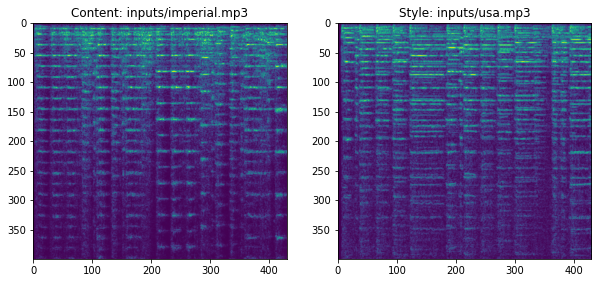

Content: inputs/imperial.mp3


Style: inputs/usa.mp3


In [ ]:
CONTENT_TITLE = 'Content: ' + CONTENT_FILENAME
STYLE_TITLE = 'Style: ' + STYLE_FILENAME

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(CONTENT_TITLE)
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title(STYLE_TITLE)
plt.imshow(a_style[:400,:])
plt.show()

print(CONTENT_TITLE)
display(Audio(CONTENT_FILENAME))
print(STYLE_TITLE)
display(Audio(STYLE_FILENAME))

Definiamo il modello

In [ ]:
N_FILTERS = 4096
KERNEL_HEIGHT = 1
KERNEL_WIDTH = 11

class CNNModel(torch.nn.Module):

  def __init__(self, kernel):
    super().__init__()
    self.conv1 = Conv2d(in_channels = N_CHANNELS, 
                        out_channels = N_FILTERS, 
                        kernel_size = (11, 1))
    self.conv1.weight = torch.nn.Parameter(kernel)
    self.relu1 = ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    return out.detach()

In [ ]:
class GramMatrix(torch.nn.Module):

  def forward(self, features, samples):
    return np.matmul(features.T, features) / samples


class StyleLoss(torch.nn.Module):

  def __init__(self, target):
    super().__init__()
    self.target = target.detach()
    self.criterion = torch.nn.MSELoss()

  def forward(self, input):
    self.output = input.clone()
    self.loss = 2 * self.criterion(self.output, self.target)
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

In [ ]:
class ContentLoss(torch.nn.Module):

  def __init__(self, target):
    super(ContentLoss, self).__init__()
    # facciamo una detach, necessaria per calolare dinamicamente il gradiente
    self.target = target.detach()
    self.criterion = torch.nn.MSELoss()

  def forward(self, alpha, input):
    self.loss = alpha * 2 * self.criterion(input, self.target)
    self.output = input
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

Calcoliamo le features di stile e contenuto.
`std` è definita come $std=\sqrt{2} \cdot \sqrt{\frac{2}{(n_{channels}+n_{fitlers}) \cdot kernel\_width}}$ e fungerà da fattore moltiplicativo per il kernel

In [ ]:
# transponiamo e permutiamo per ottenere la shape giusta da passare in input
a_content_t = torch.from_numpy(np.ascontiguousarray(a_content.T[None,None,:,:])).permute(0, 3, 1, 2)
a_style_t = torch.from_numpy(np.ascontiguousarray(a_style.T[None,None,:,:])).permute(0, 3, 1, 2)
print('input size:', a_content_t.size(), '[batch, in_channels, in_height, in_width]')

# definiamo il nostro filtro
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * KERNEL_WIDTH))
kernel = np.random.randn(N_FILTERS, N_CHANNELS, KERNEL_HEIGHT, KERNEL_WIDTH) * std
kernel = torch.from_numpy(kernel).float()
print('kernel size:', kernel.size(), '[kernel_batch, in_channels, kernel_height, kernel_width]')

# instanziamo la rete e la gram
cnn = CNNModel(kernel)
gram = GramMatrix()
if torch.cuda.is_available():
  cnn = cnn.cuda()
  gram = GramMatrix()

# calcoliamo le features
content_features = cnn(a_content_t)
print('content_features size:', content_features.size(), '[batch, out_channels, out_height, out_width]')
style_features = cnn(a_style_t)
print('style_features size:', style_features.size(), '[batch, out_channels, out_height, out_width]')

# ricaviamo la gram matrix
features = np.reshape(style_features, (-1, N_FILTERS))
print('style_features resize:', features.size(), '[out_height, out_channels]')
style_gram = gram(features, N_SAMPLES)
print('gram size:', style_gram.size())

input size: torch.Size([1, 1025, 1, 430]) [batch, in_channels, in_height, in_width]
kernel size: torch.Size([4096, 1025, 1, 11]) [kernel_batch, in_channels, kernel_height, kernel_width]
content_features size: torch.Size([1, 4096, 1, 420]) [batch, out_channels, out_height, out_width]
style_features size: torch.Size([1, 4096, 1, 420]) [batch, out_channels, out_height, out_width]
style_features resize: torch.Size([420, 4096]) [out_height, out_channels]
gram size: torch.Size([4096, 4096])


In [ ]:
ALPHA = 1e-2
learning_rate = 1e-3
iterations = 100
result = None

opt_tensor = torch.from_numpy(np.random.randn(1, N_CHANNELS, 1, N_SAMPLES).astype(np.float32) * 1e-3)
print('opt_tensor:', opt_tensor.size(), '[batch, in_channels, in_height, in_width]')
net = cnn(opt_tensor)
print('net:', net.size(), '[batch, out_channels, out_height, out_width]')

content_loss = ContentLoss(target = content_features)
style_loss = StyleLoss(target = style_gram)
if torch.cuda.is_available():
  content_loss = content_loss.cuda()
  style_loss = style_loss.cuda()
  

cl = content_loss(alpha = ALPHA, input = net)
print('cl:', cl.size())

number = net.size(1)
#height = net.size(2)
#width = net.size(3)

#size = height * width * number
feats = torch.reshape(net, (-1, number))
print('feats:', feats.size(), '[out_width, out_channels]')
feats_gram = gram(feats, N_SAMPLES)
print('feats_gram:', feats_gram.size())
sl = style_loss(input = feats_gram)
print('sl:', sl.size())

print(cl, sl)

#tl = cl + sl

opt_tensor: torch.Size([1, 1025, 1, 430]) [batch, in_channels, in_height, in_width]
net: torch.Size([1, 4096, 1, 420]) [batch, out_channels, out_height, out_width]
cl: torch.Size([1, 4096, 1, 420])
feats: torch.Size([420, 4096]) [out_width, out_channels]
feats_gram: torch.Size([4096, 4096])
sl: torch.Size([4096, 4096])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0083, 0.0085, 0.0069,  ..., 0.0072, 0.0063, 0.0069]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0011, 0.0017, 0.0000,  ..., 0.0000, 0.0007, 0.0015]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]]) tensor([[1.5149e-05, 1.4675e-05, 1.4614e-05,  ..., 4.7825e-06, 4.8418e-06,
         4.7718e-06],
        [1.4675e-05, 1.4946e-05, 1.4556e-05,  ..., 4.5644e-06, 4.6453e-06,
         4.5685e-06],
        [1.4614e-05, 1.4556e-05, 1.4885e-05,  ..., 4.7035e-06

In [ ]:
def get_style_model_and_losses(cnn, style_float, content_float = content_float, style_weight = style_weight):

  cnn = copy.deepcopy(cnn)

  style_losses = []
  content_losses = []

  # creiamo il modello
  model = nn.Sequential()

  # ci serve una Gram Matrix
  #gram = GramMatrix()

  # carichiamo tutto sulla GPU
  if torch.cuda.is_available():
    model = model.cuda()
    #gram = gram.cuda()
  
  # aggiungiamo la conv1
  model.add_module('conv1', cnn.conv1)

  # aggiungiamo la relu
  model.add_module('relu1', cnn.relu1)

  # aggiungiamo lo style loss
  target_feature = model(style_float).clone()
  target_feature_gram = gram(target_feature)
  style_loss = StyleLoss(target_feature_gram, style_weight)
  model.add_module('style_loss_1', style_loss)
  style_losses.append(style_loss)
  
  # aggiungiamo il content loss
  target = model(content_float).detach()
  content_loss = ContentLoss(target, content_weight)
  model.add_module('content_loss_1', content_loss)
  content_losses.append(content_loss)

  return model, style_losses, content_losses

# Nuovo Modello riadattato

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data

In [ ]:
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import ReLU, Conv2d
import soundfile as sf
import warnings
import copy
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
CONTENT_FILENAME = "inputs/imperial.mp3"
STYLE_FILENAME = "inputs/usa.mp3"
OUTPUT_FILENAME = "outputs/output.wav"

In [ ]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectrogram(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [ ]:
a_content, fs = read_audio_spectrogram(CONTENT_FILENAME)
a_style, fs = read_audio_spectrogram(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]

a_style = a_style[:N_CHANNELS, :N_SAMPLES] # slicing

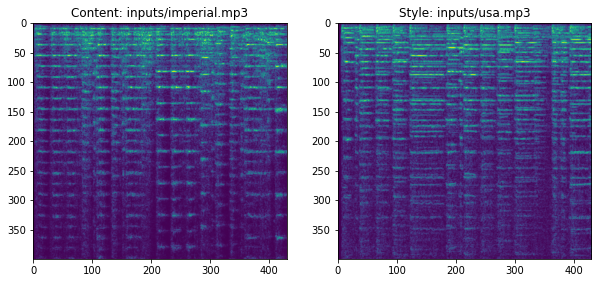

Content: inputs/imperial.mp3


Style: inputs/usa.mp3


In [ ]:
CONTENT_TITLE = 'Content: ' + CONTENT_FILENAME
STYLE_TITLE = 'Style: ' + STYLE_FILENAME

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(CONTENT_TITLE)
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title(STYLE_TITLE)
plt.imshow(a_style[:400,:])
plt.show()

print(CONTENT_TITLE)
display(Audio(CONTENT_FILENAME))
print(STYLE_TITLE)
display(Audio(STYLE_FILENAME))

In [ ]:
N_FILTERS = 4096
KERNEL_HEIGHT = 1
KERNEL_WIDTH = 11

class CNNModel(torch.nn.Module):

  def __init__(self, kernel):
    super().__init__()
    self.conv1 = Conv2d(in_channels = N_CHANNELS, 
                        out_channels = N_FILTERS, 
                        kernel_size = (11, 1))
    self.conv1.weight = torch.nn.Parameter(kernel)
    self.relu1 = ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    return out.detach()

In [ ]:
class GramMatrix(torch.nn.Module):

  def __init__(self, samples):
    self.samples = samples

  def forward(self, features):
    return np.matmul(features.T, features) / self.samples


class StyleLoss(torch.nn.Module):

  def __init__(self, target):
    super().__init__()
    self.target = target.detach()
    self.gram = GramMatrix()
    self.criterion = torch.nn.MSELoss()

  def forward(self, input):
    self.output = input.clone()
    self.G = self.gram(input)
    self.loss = 2 * self.criterion(self.output, self.target)
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

In [ ]:
class ContentLoss(torch.nn.Module):

  def __init__(self, target):
    super(ContentLoss, self).__init__()
    # facciamo una detach, necessaria per calolare dinamicamente il gradiente
    self.target = target.detach()
    self.criterion = torch.nn.MSELoss()

  def forward(self, alpha, input):
    self.loss = alpha * 2 * self.criterion(input, self.target)
    self.output = input
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

In [ ]:
def get_style_model_and_losses(cnn, a_style_t, a_content_t = a_content_t):
  cnn = copy.deepcopy(cnn)
  style_losses = []
  content_losses = []
  # creiamo il modello
  model = torch.nn.Sequential()
  # ci serve una Gram Matrix
  gram = GramMatrix(N_SAMPLES)
  # carichiamo tutto sulla GPU
  if torch.cuda.is_available():
    model = model.cuda()
    gram = gram.cuda()
  # aggiungiamo la conv1
  model.add_module('conv_1', cnn.conv1)
  # aggiungiamo la relu
  model.add_module('relu1', cnn.relu1)
  # aggiungiamo lo style loss
  target_feature = model(a_style_t).clone()
  target_feature_gram = gram(target_feature)
  print(target_feature.size(), target_feature)
  print(target_feature_gram.size(), target_feature_gram)
  style_loss = StyleLoss(target_feature_gram)
  model.add_module('style_loss_1', style_loss)
  style_losses.append(style_loss)
  # aggiungiamo il content loss
  target = model(a_content_t).detach()
  content_loss = ContentLoss(target)
  model.add_module('content_loss_1', content_loss)
  content_losses.append(content_loss)

  return model, style_losses, content_losses

In [ ]:
a_style_t = torch.from_numpy(a_style).reshape([1, N_CHANNELS, 1, N_SAMPLES])
a_content_t = torch.from_numpy(a_content).reshape([1, N_CHANNELS, 1, N_SAMPLES])

In [ ]:
# scegliere se cominciare con la copia esatta del contenuto oppure con un tensore randomico
input_content_t = a_content_t.clone()
# input_float = Variable(torch.randn(content_float.size())).type(torch.FloatTensor)

learning_rate_initial = 1e-4
num_steps = 100 # 10000

def run_style_transfer(cnn, \
                       a_style_t = a_style_t, \
                       a_content_t = a_content_t, \
                       input_content_t = input_content_t, \
                       num_steps = num_steps):
  print('Costruendo il modello per lo Style Transfer...')
  model, style_losses, content_losses = get_style_model_and_losses(cnn, a_style_t, a_content_t)
  input_param, optimizer = get_input_param_optimizer(input_content_t)
  print('Ottimizzando...')
  run = [0]

  while run[0] <= num_steps:
    def closure():
      # correggiamo i valori dell'input aggiornato
      #input_param.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(input_param)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        # print('sl vale ', sl, 'style loss vale', style_score)
        style_score += sl.loss
      
      for cl in content_losses:
        content_score += cl.loss

      #style_score *= style_weight
      #content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 10 == 0: # 100
        print('run {}:'.format(run))
        print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
        print()
      
      return style_score + content_score
    
    optimizer.step(closure)

  # ci assicuriamo che i valori siano compresi tra 0 e 1
  #input_param.data.clamp_(0, 1)

  return input_param.data

In [ ]:
output = run_style_transfer(cnn, a_style_t = a_style_t, a_content_t = a_content_t, input_content_t = input_content_t)

Costruendo il modello per lo Style Transfer...


AttributeError: ignored